# Change Raster Resolution

In [1]:
from copy import copy
from scipy.ndimage.interpolation import zoom
from IPython.display import display, HTML
from matplotlib import pyplot as plt
from osgeo import gdal, osr
from rasterio import Affine
from rasterio.rio import convert
from rasterio.warp import reproject, RESAMPLING
# local
from AlertaDengue.settings import (
    MAPSERVER_URL, RASTER_PATH, 
)

import fiona
import numpy as np
import os
import rasterio
import rasterio.plot
import rasterio.mask
# local
import AlertaDengue as alert_dengue

In [2]:
def mask_raster(src, features):
    # make raster mask
    out_image, out_transform = rasterio.mask.mask(
        src, features, crop=True, nodata=np.nan, all_touched=True
    )
    out_meta = src.meta.copy()
    
    img_type = out_image.dtype
    # cheating
    if img_type == np.float64:
        img_type = np.float64
    elif img_type == np.float32:
        img_type = np.float32
    
    out_meta.update({
        'driver': "GTiff",
        'height': out_image.shape[1],
        'width': out_image.shape[2],
        'transform': out_transform,
        'dtype': img_type # out_images[raster_name].dtype
    })
    
    return out_image, out_meta

In [3]:
def show_raster_stats(src):
    """
    """
    print('=' * 80)
    print('shape:', src.read().shape)
    print('dtypes:', src.dtypes)
    print('nodata:', src.nodata)
    for band in src.read():
        if np.isnan(band.min()):
            band = np.nan_to_num(band)
            
        print('min:', band.min())
        print('mean:', band.mean())
        print('median:', np.median(band))
        print('max:', band.max())
        

In [4]:
def show_raster_panel_info(src, vmin, vmax):
    """
    
    """
    show_raster_stats(src)
    print('vmin:', vmin)
    print('vmax:', vmax)

    rasterio.plot.show(
        (src, 1), with_bounds=True, cmap='gnuplot',
        vmin=vmin, vmax=vmax
    )

In [5]:
def get_raster_key(raster_name, to_lower=True):
    """
    """
    if raster_name[-14:].count('_') == 2:
        raster_key = raster_name[:-15]
    else:
        raster_key = raster_name[:-19]
    
    if to_lower:
        raster_key = raster_key.lower()
        
    return raster_key

In [6]:
def get_date_from_file_name(raster_name, to_lower=True):
    """
    """
    if raster_name[-14:].count('_') == 2:
        dt = raster_name[-14:-4]
    else:
        dt = raster_name[-18:-8]

    return datetime.strptime(dt, '%Y_%m_%d')


## Setup

In [7]:
raster_dir_path = RASTER_PATH
meteorological_dir_path = os.path.join(raster_dir_path, 'meteorological')

data_range = {
    'ndvi': (-2000.0, +10000.0),
}

geocode = 3304557

shp_path = '%s/static/shapefile' % os.path.dirname(alert_dengue.__path__[0])
shapefile_path = os.path.join(shp_path, '%s.shp' % geocode)

In [8]:
# using fiona to get coordintes
with fiona.open(shapefile_path, "r") as shapefile:
    features = [feature["geometry"] for feature in shapefile]

In [9]:
raster_name = 'NDVI_2010_09_30.tif'
raster_key = get_raster_key(raster_name)

vmin, vmax = data_range[raster_key]

## Mask raster using shapefile

ORIGINAL RASTER MASKED
shape: (1, 8, 17)
dtypes: ('float64',)
nodata: None
min: -414.0
mean: 2422.6617647058824
median: 2393.0
max: 7673.0
vmin: -2000.0
vmax: 10000.0


/home/xmn/miniconda3/envs/alertadengue/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


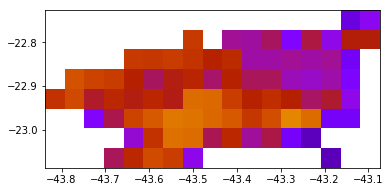

In [10]:
ndvi_country_path = os.path.join(
    meteorological_dir_path, 'country', 'ndvi', raster_name
)

ndvi_rj_name = '%s_%s' % (geocode, raster_name)
ndvi_rj_path = os.path.join(os.sep, 'tmp', ndvi_rj_name)

with rasterio.open(ndvi_country_path) as ndvi_country_src:
    ndvi_rj_image, ndvi_rj_meta = mask_raster(
        ndvi_country_src, features
    )

    with rasterio.open(ndvi_rj_path, "w", **ndvi_rj_meta) as ndvi_rj_src:
        print('ORIGINAL RASTER MASKED')
        ndvi_rj_src.write(ndvi_rj_image)
        show_raster_panel_info(ndvi_rj_src, vmin, vmax)
# Rio de Janeiro raster file        
src_rj = rasterio.open(ndvi_rj_path)
ndvi_rj_meta = src_rj.profile
ndvi_rj_image = src_rj.read()

ndvi_rj_aff = (
    src_rj.profile['transform'] 
    if not isinstance(src_rj.profile['transform'], tuple) else
    src_rj.profile['affine']
)

## Change Resolution

In [11]:
res = 4

### Using Rasterio reproject

shape: (1, 32, 68)
dtypes: ('float64',)
nodata: None
min: 0.0
mean: 922.7480887244806
median: 0.0
max: 7621.462886810471
vmin: -2000.0
vmax: 10000.0


/home/xmn/miniconda3/envs/alertadengue/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


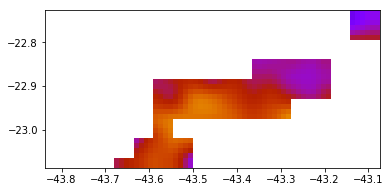


ORIGINAL RESOLUTION
shape: (1, 8, 17)
dtypes: ('float64',)
nodata: None
min: -414.0
mean: 2422.6617647058824
median: 2393.0
max: 7673.0
vmin: -2000.0
vmax: 10000.0


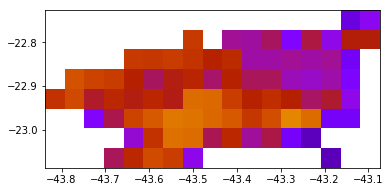

In [12]:
ndvi_rj_res1_name = '%s_res1_%s' % (geocode, raster_name)

ndvi_rj_res1_path = os.path.join(
    os.sep, 'tmp', ndvi_rj_res1_name
)

ndvi_rj_res1_image = ndvi_rj_image.copy()
ndvi_rj_res1_meta = dict(ndvi_rj_meta)
ndvi_rj_res1_aff = copy(ndvi_rj_aff)

ndvi_rj_res1_image = np.empty(
    shape=(
        ndvi_rj_res1_image.shape[0],  # same number of bands
        round(ndvi_rj_res1_image.shape[1] * res), # resolution * 100%
        round(ndvi_rj_res1_image.shape[2] * res)
    ), dtype=ndvi_rj_res1_image.dtype
)

# adjust the new affine transform to the 150% smaller cell size
# identity(), translation(), scale(), shear(), and rotation()
ndvi_rj_res1_aff_new = Affine(
    ndvi_rj_aff.a / res, 
    ndvi_rj_aff.b, 
    ndvi_rj_aff.c,
    ndvi_rj_aff.d, 
    ndvi_rj_aff.e / res, 
    ndvi_rj_aff.f
)

ndvi_rj_res1_aff, ndvi_rj_res1_aff_new

reproject(
    source=ndvi_rj_image, 
    src_transform = ndvi_rj_aff,
    src_crs = ndvi_rj_meta['crs'],
    destination=ndvi_rj_res1_image,
    dst_transform = ndvi_rj_res1_aff_new,
    dst_crs = ndvi_rj_res1_meta['crs'],
    resampling = RESAMPLING.cubic
)

ndvi_rj_res1_meta['transform'] = ndvi_rj_res1_aff_new
ndvi_rj_res1_meta['affine'] = ndvi_rj_res1_aff_new
ndvi_rj_res1_meta['width'] *= res
ndvi_rj_res1_meta['height'] *= res

with rasterio.open(ndvi_rj_res1_path, "w", **ndvi_rj_res1_meta) as dst:
    dst.write(ndvi_rj_res1_image)
    show_raster_panel_info(dst, vmin, vmax)
    
    print('\nORIGINAL RESOLUTION')
    show_raster_panel_info(src_rj, vmin, vmax)

### Using SciPy


NEW RESOLUTION
shape: (1, 32, 68)
dtypes: ('float64',)
nodata: None
min: 0.0
mean: 1466.2507536017006
median: 0.0
max: 7158.230286695288
vmin: -2000.0
vmax: 10000.0


/home/xmn/miniconda3/envs/alertadengue/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


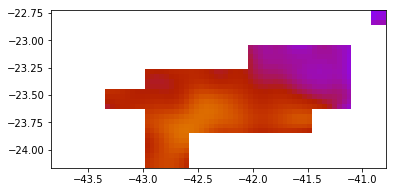


ORIGINAL RESOLUTION
shape: (1, 8, 17)
dtypes: ('float64',)
nodata: None
min: -414.0
mean: 2422.6617647058824
median: 2393.0
max: 7673.0
vmin: -2000.0
vmax: 10000.0


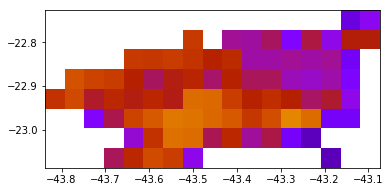

In [13]:
ndvi_rj_res2_name = '%s_res2_%s' % (geocode, raster_name)

ndvi_rj_res2_path = os.path.join(
    os.sep, 'tmp', ndvi_rj_res2_name
)

ndvi_rj_res2_image = zoom(
    ndvi_rj_image, zoom=[1, res, res], order=2, prefilter=False
)

# Adjust original affine transform
ndvi_rj_res2_meta = dict(ndvi_rj_meta)
ndvi_rj_res2_aff = copy(ndvi_rj_aff)
ndvi_rj_res2_meta['transform'] = Affine(
    ndvi_rj_aff.a / res, 
    ndvi_rj_aff.b, 
    ndvi_rj_aff.c,
    ndvi_rj_aff.d, 
    ndvi_rj_aff.e / res, 
    ndvi_rj_aff.f
)
ndvi_rj_res2_meta['transform'] = ndvi_rj_res2_meta['affine']

ndvi_rj_res2_meta['width'] *= res
ndvi_rj_res2_meta['height'] *= res

with rasterio.open(ndvi_rj_res2_path, "w", **ndvi_rj_res2_meta) as dst:
    dst.write(ndvi_rj_res2_image)
    print('\nNEW RESOLUTION')
    show_raster_panel_info(dst, vmin, vmax)
    
    print('\nORIGINAL RESOLUTION')
    show_raster_panel_info(src_rj, vmin, vmax)

### Using decimated read


NEW RESOLUTION
shape: (1, 32, 68)
dtypes: ('float64',)
nodata: None
min: -414.0
mean: 2422.6617647058824
median: 2393.0
max: 7673.0
vmin: -2000.0
vmax: 10000.0


/home/xmn/miniconda3/envs/alertadengue/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


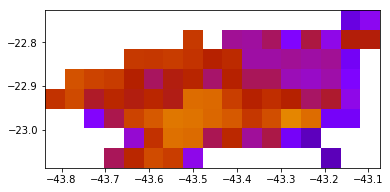


ORIGINAL RESOLUTION
shape: (1, 8, 17)
dtypes: ('float64',)
nodata: None
min: -414.0
mean: 2422.6617647058824
median: 2393.0
max: 7673.0
vmin: -2000.0
vmax: 10000.0


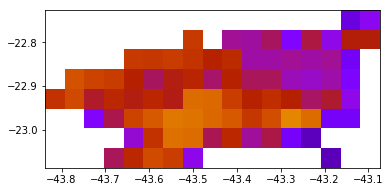

In [14]:
ndvi_rj_res3_name = '%s_res3_%s' % (geocode, raster_name)
ndvi_rj_res3_path = os.path.join(
    os.sep, 'tmp', ndvi_rj_res3_name
)

with rasterio.open(ndvi_rj_path) as src:
    ndvi_rj_res3_image = src.read()

    newarr = np.empty(
        shape=(
            ndvi_rj_res3_image.shape[0],  # same number of bands
            round(ndvi_rj_res3_image.shape[1] * res), # double resolution
            round(ndvi_rj_res3_image.shape[2] * res))
    )

    ndvi_rj_res3_image = src.read(out=newarr).copy()
    ndvi_rj_res3_meta = dict(src.profile)

ndvi_rj_res3_aff = copy(ndvi_rj_res3_meta['affine'])
ndvi_rj_res3_meta['transform'] = Affine(
    ndvi_rj_res3_aff.a / res, 
    ndvi_rj_res3_aff.b, 
    ndvi_rj_res3_aff.c,
    ndvi_rj_res3_aff.d, 
    ndvi_rj_res3_aff.e / res, 
    ndvi_rj_res3_aff.f
)
ndvi_rj_res3_meta['affine'] = ndvi_rj_res3_meta['transform']
ndvi_rj_res3_meta['width'] *= res
ndvi_rj_res3_meta['height'] *= res

with rasterio.open(ndvi_rj_res3_path, "w", **ndvi_rj_res3_meta) as dst:
    dst.write(ndvi_rj_res3_image)
    print('\nNEW RESOLUTION')
    show_raster_panel_info(dst, vmin, vmax)
    
    print('\nORIGINAL RESOLUTION')
    show_raster_panel_info(src_rj, vmin, vmax)

## MASK + CHANGE + MASK

MASK + CHANGE RESOLUTION + MASK
shape: (1, 31, 63)
dtypes: ('float64',)
nodata: None
min: -414.0
mean: 2205.9400921658985
median: 609.0
max: 7673.0
vmin: -2000.0
vmax: 10000.0


/home/xmn/miniconda3/envs/alertadengue/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


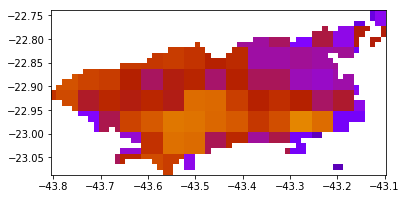

In [15]:
ndvi_rj_final_name = '%s_final_%s' % (geocode, raster_name)

ndvi_rj_final_path = os.path.join(
    os.sep, 'tmp', ndvi_rj_final_name
)

with rasterio.open(ndvi_rj_res3_path) as dst:
    ndvi_rj_final_image, ndvi_rj_final_meta = mask_raster(dst, features)

with rasterio.open(ndvi_rj_final_path, "w", **ndvi_rj_final_meta) as dst:
    dst.write(ndvi_rj_final_image)
    print('MASK + CHANGE RESOLUTION + MASK')
    show_raster_panel_info(dst, vmin, vmax)

    